## modeling on the balanced data
- in this note book I will have the following models run with the balanced data:
- logistic regression
- SVM, DenseNet 
- transfer learning (resnet50v2)
- transfer learning (DenseNet)

## Table of Contents
- Sampling
- Scaling
- Feature Engineering
-  Modeling 
- Conclusion

In [2]:
# Importing the required Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
import cv2 as cv2
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

In [2]:
# reading The saved daaframe that was created in the EDA and unbalanced class models
retina_df = pd.read_csv('retina_df.csv')


## Sampling the data
- split the data into remaining and test set 
- splitting the remaining data into training and validation set to perform Model training.
#### Important notes
- I made sure that both eyes belonging to a patient are in the same set. It wouldn't be fair if a patient had one eye in training and one eye in test specially that If you'd have DR in one Eye then there is a very high chance of having DR in the other eye.

In [33]:
# splitting the data while making sure patients have both eyes in all sets
rem, test = next(GroupShuffleSplit(test_size=.15, n_splits=2, random_state = 7).split(retina_df, groups=retina_df['Patient_id']))

rem_df = retina_df.iloc[rem]
test_df = retina_df.iloc[test]

In [34]:
# splitting the remaining sample into train and validation
train, validation = next(GroupShuffleSplit(test_size=.15, n_splits=2, random_state = 7).split(rem_df, groups=rem_df['Patient_id']))

train_df = rem_df.iloc[train]
validation_df = rem_df.iloc[validation]

In [35]:
# checking the shape of my Data
print(train_df.shape)
print(test_df.shape)
print(validation_df.shape)

(25376, 6)
(5270, 6)
(4480, 6)


checking if the Target column is distributed similarly between the training, testing and validation sets

In [36]:
# checking for the class percentage by grouping by the class
print((test_df.groupby('level')['level'].count()/5270*100).reset_index(drop = True))
print((validation_df.groupby('level')['level'].count()/4480*100).reset_index(drop = True))
print((train_df.groupby('level')['level'].count()/25376*100).reset_index(drop = True))

0    72.182163
1     7.039848
2    16.508539
3     2.163188
4     2.106262
Name: level, dtype: float64
0    73.549107
1     6.584821
2    14.866071
3     2.790179
4     2.209821
Name: level, dtype: float64
0    73.735025
1     7.002680
2    14.801387
3     2.498424
4     1.962484
Name: level, dtype: float64


the differance in class distribution between the sets is very small

### Creating a balanced class Training set
- this balanced class Training set will be used to train SVM and Logistics regression models. I will create a larger one with  Data augmentation for the Transfer learning models.
- I will down sample class (no DR) in the training set so that all classes are equal to the minority class 4(Proliferative diabetic retinopathy ).

In [7]:
# taking a class balanced sample of the data
train_df_balanced = train_df.groupby(['level', 'Eye_left']).apply(lambda x: x.sample(250, replace = True)
                                                      ).reset_index(drop = True)

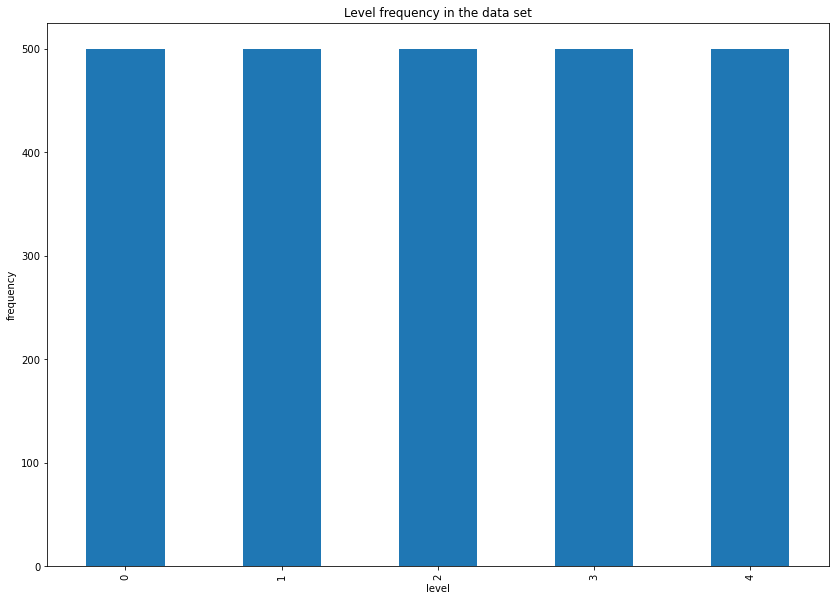

level
0    500
1    500
2    500
3    500
4    500
Name: level, dtype: int64


In [8]:
# checking if all classes are balanced
plt.figure(figsize = (14,10))
train_df_balanced.groupby('level')['level'].count().plot(kind = 'bar')

plt.ylabel('frequency')
plt.title('Level frequency in the data set')
plt.show()
print(train_df_balanced.groupby('level')['level'].count())

the training sample data is now 2500 in total with 500 of each class. 
Important to note
- whenever I would only manipulate the class balance for the training set to allow my train to learn more from the minority classes. 
- I would leave the balance the way it is with the validation and test data.

For a Fair comparison between models and Limitation In memory. 
- I will run my models with the global histogram equalization. 
- That means they will be a 1 dimention grey Images

Turning the images to a numpay array then flattening. this will alow the data to be fed to manchine learning models 

In [9]:
# turning the images into flat numpy array
X_rem_sample = np.zeros((2500,400*400), dtype=np.uint8)
for i,img in enumerate(train_df_balanced['path']):
    
    image= Image.open(img)
    np_img = numpy.array(image)
    
    
    X_rem_sample[i] = np_img.ravel()
    print(f'{i},{img} appeneded')


0,train\2217_right.jpeg appeneded
1,train\21529_right.jpeg appeneded
2,train\43957_right.jpeg appeneded
3,train\19070_right.jpeg appeneded
4,train\23993_right.jpeg appeneded
5,train\31231_right.jpeg appeneded
6,train\26628_right.jpeg appeneded
7,train\40197_right.jpeg appeneded
8,train\20775_right.jpeg appeneded
9,train\13672_right.jpeg appeneded
10,train\27920_right.jpeg appeneded
11,train\34997_right.jpeg appeneded
12,train\36362_right.jpeg appeneded
13,train\4394_right.jpeg appeneded
14,train\1021_right.jpeg appeneded
15,train\35595_right.jpeg appeneded
16,train\34932_right.jpeg appeneded
17,train\31511_right.jpeg appeneded
18,train\617_right.jpeg appeneded
19,train\22838_right.jpeg appeneded
20,train\28208_right.jpeg appeneded
21,train\8968_right.jpeg appeneded
22,train\43421_right.jpeg appeneded
23,train\35377_right.jpeg appeneded
24,train\8695_right.jpeg appeneded
25,train\39727_right.jpeg appeneded
26,train\40473_right.jpeg appeneded
27,train\15206_right.jpeg appeneded
28,train\

Taking a smaler sample of the test data (10%),
so I won't run out of memory when Turning my Images into a numpay array.

In [10]:
# taking a sample of the main data frame while stratifying the target column
from sklearn.model_selection import train_test_split
test_df_sample, sample_to_drop = train_test_split(test_df, train_size=.20, stratify=test_df['level'], random_state=42)

In [11]:
test_df_sample.shape

(1054, 6)

New test sample has now 1054 rows

In [12]:
# turning the images into flat numpy array
X_test_sample = np.zeros((1054,400*400), dtype=np.uint8)
for i,img in enumerate(test_df_sample['path']):
    
    image= Image.open(img)
    np_img = numpy.array(image)
    
    X_test_sample[i] = np_img.ravel()
    print(f'{i},{img} appeneded')


0,train\44029_left.jpeg appeneded
1,train\13296_left.jpeg appeneded
2,train\11417_left.jpeg appeneded
3,train\2095_right.jpeg appeneded
4,train\32024_left.jpeg appeneded
5,train\17871_right.jpeg appeneded
6,train\23904_right.jpeg appeneded
7,train\38420_left.jpeg appeneded
8,train\10260_left.jpeg appeneded
9,train\27643_left.jpeg appeneded
10,train\41918_left.jpeg appeneded
11,train\18253_right.jpeg appeneded
12,train\35915_left.jpeg appeneded
13,train\27876_right.jpeg appeneded
14,train\40262_right.jpeg appeneded
15,train\4304_right.jpeg appeneded
16,train\21195_right.jpeg appeneded
17,train\23073_left.jpeg appeneded
18,train\14824_left.jpeg appeneded
19,train\42217_right.jpeg appeneded
20,train\13527_left.jpeg appeneded
21,train\14943_left.jpeg appeneded
22,train\43641_right.jpeg appeneded
23,train\44331_right.jpeg appeneded
24,train\17173_left.jpeg appeneded
25,train\11206_right.jpeg appeneded
26,train\29057_right.jpeg appeneded
27,train\16946_right.jpeg appeneded
28,train\33577_lef

In [13]:
# assigning the target column
y_test = test_df_sample['level']
y_rem = train_df_balanced['level']

### Scaling my data using a Min max scaler to normalize the pixels
- I also changed the type of the data to float32 to reduce memory usage.

In [14]:
# scalling the numpay array 
scaler = MinMaxScaler()
# fitting on the remaining data
scaler.fit(X_rem_sample)
# transforming both data sets
X_rem_scaled = scaler.transform(X_rem_sample)
X_test_scaled = scaler.transform(X_test_sample)
# changing the type to float32 to reduce memory usage
X_test_scaled = X_test_scaled.astype(np.float32)
X_rem_scaled = X_rem_scaled.astype(np.float32)

Saving my scaled features as a pickeled file

In [15]:
# Pickeling my scaled test data
filename = 'scaled_test_sample_balanced'
outfile = open(filename,'wb')
pickle.dump(X_test_scaled,outfile)
outfile.close()

In [16]:
# Pickeling my scaled train data
filename = 'scaled_rem_sample_balanced'
outfile = open(filename,'wb')
pickle.dump(X_rem_scaled,outfile)
outfile.close()

In [ ]:
# to load the pickeled data 
infile_rem = open('scaled_rem_sample','rb')
X_rem_scaled = pickle.load(infile_rem)
infile_rem.close()

infile_test = open('scaled_test_sample','rb')
X_test_scaled = pickle.load(infile_test)
infile_test.close()

### Feature engendering with PCA
- using feature engendering to reduce the number of my dimensions while maintaining 0.999% of the data
- this will get rid of all the black frame around the retina images as PCA will remove features with very low variance. 
- My model was not able to run without PCA as it have 160000 features.

In [17]:

# applying PCA to the sampled Data
pca = PCA(n_components=.999)
pca.fit(X_rem_scaled)

# transform data 
X_rem_PCA = pca.transform(X_rem_scaled)
X_test_PCA = pca.transform(X_test_scaled)


In [39]:
X_test_PCA.shape

(1054, 1806)

PCA reduced my dimensions from 16000 to 1806 while maintaining 0.999% of the data information.

Saving my New features as a pickeled file

In [18]:
# saving the pickeled x_rem_PCA data

filename = 'PCA_test_sample_balanced'
outfile = open(filename,'wb')
pickle.dump(X_rem_PCA,outfile)
outfile.close()
# saving the pickeled x_rem_PCA data
filename = 'PCA_rem_sample_balanced'
outfile = open(filename,'wb')
pickle.dump(X_test_PCA,outfile)
outfile.close()

This code below is for loading my pickled X_test and X_remaining PCA data

In [ ]:
# to load the pickeled  PCA files
infile_rem = open('PCA_rem_sample_balanced','rb')
X_rem_PCA = pickle.load(infile_rem)
infile_rem.close()

infile_test = open( 'PCA_test_sample_balanced','rb')
X_test_PCA = pickle.load(infile_test)
infile_test.close()

In [20]:
print(X_test_PCA.shape)
print(X_rem_PCA.shape)

(1054, 1806)
(2500, 1806)


### fitting balanced  class data to Logistic regression Model
- optimizing for value of C.
- Using a liblinear Solver 
- max_iter of 2000
- using cross validation to find the best value of C.


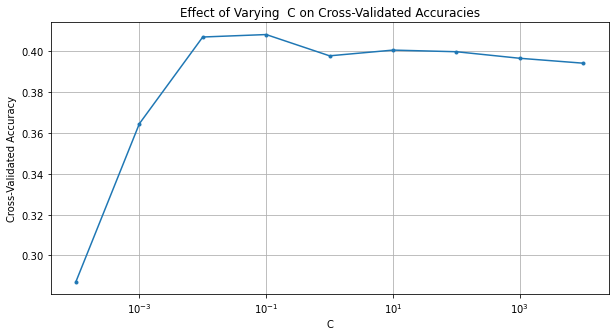

The best model has a depth =  0.1


In [28]:
# creating an empty list to append the validation scores to it
vc_acc_scores = []


# setting the values of C that I want to test
C_values = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000,10000]


for c in C_values:

    retina_logmodel_cv = LogisticRegression(solver='liblinear', C = c,max_iter=2000).fit(X_rem_PCA, y_rem)

    
    #cross validation
    cv_accuracy = np.mean(cross_val_score(retina_logmodel_cv, X_rem_PCA, y_rem, cv=5, n_jobs=-1))
    vc_acc_scores.append(cv_accuracy)

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(C_values, vc_acc_scores, marker = '.')
plt.title('Effect of Varying  C on Cross-Validated Accuracies')
plt.xscale('log') 
plt.xlabel('C')
plt.ylabel('Cross-Validated Accuracy')
plt.grid()
plt.show()
which_vc = np.array(vc_acc_scores).argmax()

print("The best model has a depth = ",C_values[which_vc] )


Cross validation score peaked at almost 41% accuracy with a C value of 0.1
\
 let's see how the model will perform on the test data

In [29]:
# fitting a logestic regression with C value of 0.01

retina_logmodel_cv = LogisticRegression(solver='liblinear', C = C_values[which_vc],max_iter=2000).fit(X_rem_PCA, y_rem)
print(retina_logmodel_cv.score(X_test_PCA, y_test))
    # get predicted y values for the test set

test_score = retina_logmodel_cv.score(X_test_PCA, y_test)
y_pred = retina_logmodel_cv.predict(X_test_PCA)

# generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# get target names
cols = y_test.unique()

# convert to a DataFrame
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted No DR", "Predicted Mild DR"
           ,"Predicted Moderate DR"
           ,"Predicted Sever DR"
           ,"Predicted Proliferative DR"],
    index=["True No DR", "True Mild DR"
           ,"True Moderate DR"
           ,"True Sever DR"
           ,"True Proliferative DR"])


print(f'test accuracy is: {test_score}')
display(cf_df)

# Classification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)




0.2998102466793169
test accuracy is: 0.2998102466793169


,Predicted No DR,Predicted Mild DR,Predicted Moderate DR,Predicted Sever DR,Predicted Proliferative DR
True No DR,242,181,156,87,95
True Mild DR,17,22,11,12,12
True Moderate DR,58,33,42,19,22
True Sever DR,5,1,7,7,3
True Proliferative DR,5,5,7,2,3


              precision    recall  f1-score   support

           0       0.74      0.32      0.44       761
           1       0.09      0.30      0.14        74
           2       0.19      0.24      0.21       174
           3       0.06      0.30      0.09        23
           4       0.02      0.14      0.04        22

    accuracy                           0.30      1054
   macro avg       0.22      0.26      0.19      1054
weighted avg       0.57      0.30      0.37      1054



The models test accuracy is 30%. the Model has performed a lot worse than the same model with unbalanced classes, if we look at the heat map below we notice that the model was able to predict the other classes, in comparison to the unbalanced Logistic regression model that was only able to predict Level 0 (no DR). 
- The Precision for the Negative DR are quit high 74%.
- on the other hand the precision and recall for all the other classes are low, but much higher than the unbalanced Model.
- We notice that the Recall is better better than precision for classes that indicated DR.
- the results are not satisfactory yet.


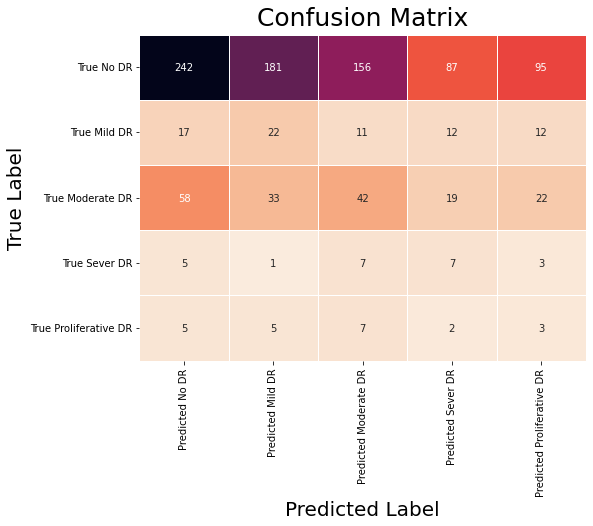

In [30]:
# plotting the confusion matrix
plt.figure(figsize = (8,6))
sns.heatmap(cf_df ,
            annot=True,
            fmt='g',
            cbar=False,
            cmap="rocket_r",
            linewidths=1,           
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

### Fitting Balanced Classes data on Support Vector Machine
- performing cross validation to find the optimal Value of c_candidates
- using the kernel rbf which is a non linear SVM and it can perform better classification. 

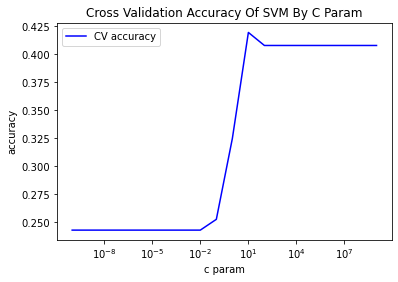

The best model has a depth =  10.0


In [31]:
#defining the values of C that I want to test
c_candidates = 10**np.arange(-10.0,10.0)

vc_acc = []


# need to loop through the hyperperameter C values to optimize the model

for c in c_candidates:
    
    SVM = SVC(C = c, kernel = 'rbf')
    SVM.fit( X_rem_PCA,y_rem)
# Cross validation   
    cv_accuracy = np.mean(cross_val_score(SVM, X_rem_PCA, y_rem, cv=5, n_jobs=-1))
    vc_acc.append(cv_accuracy)
# plotting cross val accuracy
plt.figure()
plt.plot(c_candidates,vc_acc,c = 'blue',label = 'CV accuracy')
plt.xscale('log')
plt.legend()
plt.xlabel('c param')
plt.ylabel('accuracy')
plt.title('Cross Validation Accuracy Of SVM By C Param')
plt.show()
which_vc = np.array(vc_acc).argmax()

print("The best model has a depth = ",c_candidates[which_vc] )

 Cross validation accuracy peacked at c = 10 and scored 42% accuracy
- I will use the C value of 10 to run the model on my test set Below

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SVM =SVC(C = c_candidates[which_vc], kernel = 'rbf')
SVM.fit( X_rem_PCA,y_rem)
print(SVM.score(X_test_PCA, y_test))
    # get predicted y values for the test set

test_score = SVM.score(X_test_PCA, y_test)
y_pred = SVM.predict(X_test_PCA)

# generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)



# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted No DR", "Predicted Mild DR"
           ,"Predicted Moderate DR"
           ,"Predicted Sever DR"
           ,"Predicted Proliferative DR"],
    index=["True No DR", "True Mild DR"
           ,"True Moderate DR"
           ,"True Sever DR"
           ,"True Proliferative DR"])
display(cf_df)

print(f'test accuracy is: {test_score}')


# Classification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)


0.3206831119544592


,Predicted No DR,Predicted Mild DR,Predicted Moderate DR,Predicted Sever DR,Predicted Proliferative DR
True No DR,269,189,160,72,71
True Mild DR,22,20,17,8,7
True Moderate DR,67,26,38,21,22
True Sever DR,6,5,7,3,2
True Proliferative DR,4,5,5,0,8


test accuracy is: 0.3206831119544592
              precision    recall  f1-score   support

           0       0.73      0.35      0.48       761
           1       0.08      0.27      0.13        74
           2       0.17      0.22      0.19       174
           3       0.03      0.13      0.05        23
           4       0.07      0.36      0.12        22

    accuracy                           0.32      1054
   macro avg       0.22      0.27      0.19      1054
weighted avg       0.56      0.32      0.39      1054



The SVM test accuracy is only 32%. 
- It again performed better than Logistic regression but behaved similarly when it came to to recall and precision. 
- SVM has a higher recall when comparing to Precision in all classes except for Class (0) where it has a high Precision score of 73. again neither SVMs results are satisfactory.

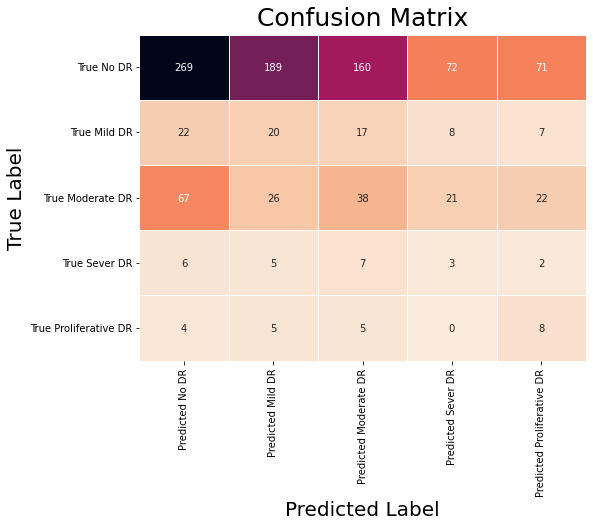

In [40]:
# plotting the confusion matrix

plt.figure(figsize = (8,6))
sns.heatmap(cf_df ,
            annot=True,
            fmt='g',
            cbar=False,
            cmap="rocket_r",
            linewidths=1,
           )
plt.title('Confusion Matrix')
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)



plt.show()

## Transfer Learning
- I performed 2 Transfer learning models 
- Resnet 50 
- DenseNet

### Creating a balanced class Trainig set
By duplicating the minority classes then applying many different image augmentation methods to make all the duplicated images slightly different in order for the models to learn from them and be able to predict the correct class.
- I chose to take 5000 images from each class. the Negative DR will not have any duplicated Images but All the other classes will.
- Grouping by the Level and Eye_left then taking 2 2500 sample from each class as there are a left and right eye this will duplicate the 2500.

In [ ]:
# taking a class balanced sample of the data
train_df_balanced = train_df.groupby(['level', 'Eye_left']).apply(lambda x: x.sample(2500, replace = True)
                                                      ).reset_index(drop = True)

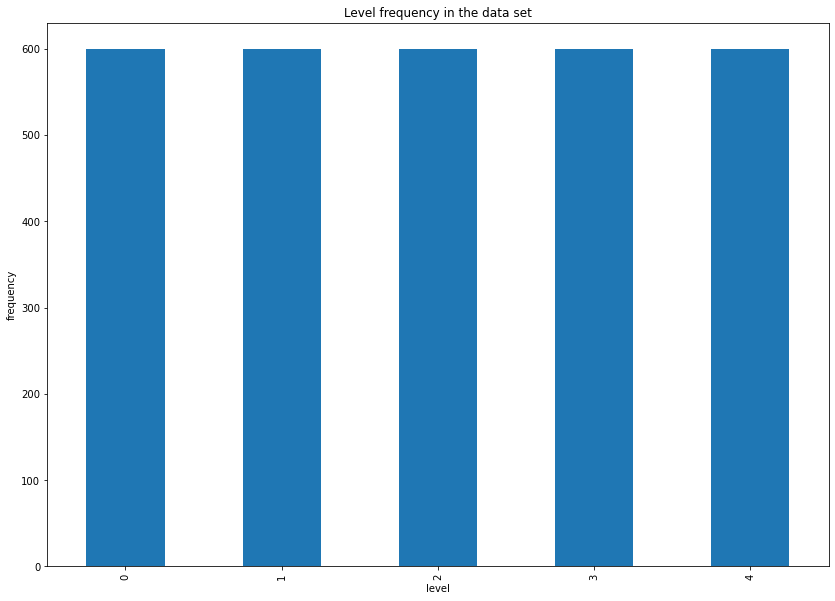

level
0    600
1    600
2    600
3    600
4    600
Name: level, dtype: int64


In [ ]:
# checking if all classes are balanced
plt.figure(figsize = (14,10))
train_df_balanced.groupby('level')['level'].count().plot(kind = 'bar')

plt.ylabel('frequency')
plt.title('Level frequency in the data set')
plt.show()
print(train_df_balanced.groupby('level')['level'].count())

Turning the Classes into type string as the Image Data generator Flow From Directory accepts only target with the type string.

In [52]:
train_df_balanced['level'] = train_df_balanced['level'].astype(str)
validation_df['level']= validation_df['level'].astype(str)
test_df['level']= test_df['level'].astype(str)

C:\Users\zedal\AppData\Local\Temp/ipykernel_2480/2534027173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['level']= validation_df['level'].astype(str)
C:\Users\zedal\AppData\Local\Temp/ipykernel_2480/2534027173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['level']= test_df['level'].astype(str)


I created a function that blurs Images so i can perform as many different augmentations on my duplicated images to make them unique.

In [53]:
# BLURRING FUNCTION
def blur(img):
    ''' this function will blur the input Image and return it'''
    
    return (cv2.blur(img,(4,4)))

I will Be using Image Data generator to train my models using small batches.
Before Feeding Images into the model I will First need to perform:
- Image augmentation is a very important step before training Images  (rotation, scaling, flipping,shear,Brightness adjustment,horizontal flip,vertical flip,blurring, rescaling and zooming) all the augmentations will be slightly increased in comparison to the CNN model that was trained on unbalanced classes. The goal is to make the duplicated images as different as possible.
- I will rescale the validation data set as well
- My images will have a shape of 400*400 pixels and 3 channels.
- I will use the method flow from dataframe and specify the Path for the images and the target.
- this will allow my data generator to extract images from the directory and feed them to the model.
- I tried different Batch sizes and 75 was the biggest batch that My local gpu can handel.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# specifying the image hight width and channels
height = 400 
width = 400
channels = 3 
# applying random image augmentation
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range = 40,
                                   shear_range=0.2,
                                   zoom_range=0.15,
                                   brightness_range=[0.2,.5],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=blur
                                   )
# rescaling the validation images
Validation_datagen = ImageDataGenerator(rescale=1./255)
                                   
                                   
                                   
# geneerating my train data                                  
Train_df_gen = train_datagen.flow_from_dataframe(
    train_df_balanced, y_col='level',x_col = 'path',
     color_mode='rgb',path_col = train_df_balanced['path'],
     class_mode='categorical', shuffle=True, target_size=(height,width),
                                                 
                                                 batch_size=75
                                                 
    
    
)
# generating my test data
Val_df_gen = Validation_datagen.flow_from_dataframe(
    validation_df, y_col='level',x_col = 'path',
     color_mode='rgb',path_col = validation_df['path'],
     class_mode='categorical', batch_size=75, shuffle=True,target_size=(height,width)
                                                 
                                                 )

Found 25000 validated image filenames belonging to 5 classes.
Found 4216 validated image filenames belonging to 5 classes.


Here are 4 images from the validation set.

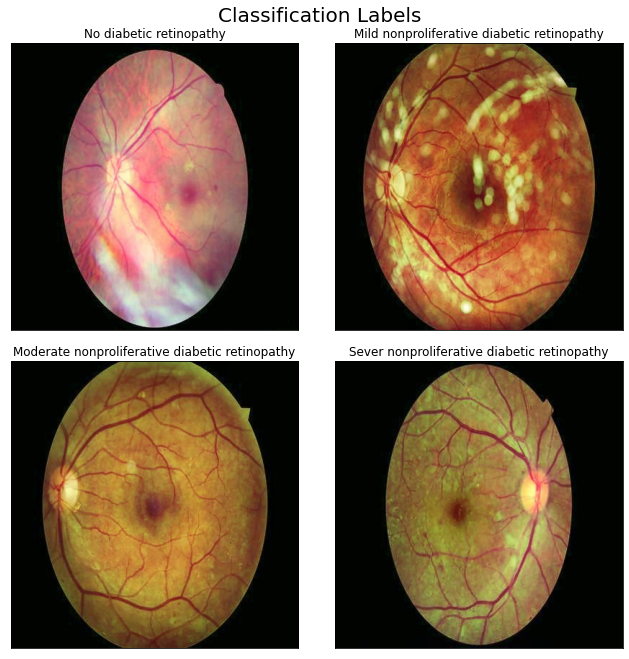

In [55]:
# Grab a batch of images from our validation generator: 
x, y = Val_df_gen.next() 

# Our images labels are one-hot encoded, lets 
# convert them to ordinal encoding
labels = np.argmax(y, axis=1)

diabetes_levels = ['No diabetic retinopathy',
                'Mild nonproliferative diabetic retinopathy',
               'Moderate nonproliferative diabetic retinopathy',
                'Sever nonproliferative diabetic retinopathy',
                'Proliferative diabetic retinopathy '
                ]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(9, 14))
ax = ax.flatten()

for i in range(0,5):
    
    index = np.argmax(labels==i) 
    ax[i].imshow(x[index])
    
    # Set the title of the subplot
    ax[i].set_title(diabetes_levels[i])
    
    # Hide the x and y ticks
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])
    

fig.suptitle("Classification Labels", size = 20)
fig.tight_layout()

# Delete the two unused subplots
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])

### RESNET50 MODEL
- I first will download RESNET50 model from the keras model Library.
- RESNET50 is a pre-trained model.
- I will use the top Layers of the RESNET50 model and specify the shape of my input.
- I'll freeze all the layers so that non of them are trainable.
- I will use the weights imagenet.

In [ ]:
from tensorflow.keras.applications import ResNet50V2
# download the pretrained weights
model_resnet = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,3))
# freeze the layers
for layer in model_resnet.layers:
    layer.trainable = False
model_resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 406, 406, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 200, 200, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

I will now add the last Layers. RESNET50 has 23,564,800 parameters, by freezing them they all become Non-trainable
- first i'll specify the the ResNet50V2 model output so that my layers will run after RESNET layers.
- then I will flatten the images 
- I will add some dense Layers this will use the features that were learned from the RESNET layers to make the final prediction.
- last I will add a softmax layer to make the prediction with 5 predictions (number of classes)
\


In [ ]:
from tensorflow.keras.models import Model

x = model_resnet.output 
x = Flatten()(x) 
# x = Dense(265, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
# x = Dense(32, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model_resnet = Model(inputs=model_resnet.input, 
              outputs=output)

compiling the model I used Adam optimizer with learning rate of 0.001. the loss has to be categorical_crossentropy.
- fitting the model to the training and validation data
- I ran the model for 85 epochs. 
- I didn't use early stop for this specific model because when I used it before the model stopped after 7 epochs and wasn't able to predict any of the positive classes. I wanted to see if the test results will improve even if the model overfit
- I saved the model history and the model weights.

In [ ]:
from keras.callbacks import CSVLogger
# Save the history of the model to a pandas dataframe
csv_logger = CSVLogger("resnet_model_history_log.csv", append=True)

# Compile the model
model_resnet.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# fit the model
resnet_history = model_resnet.fit(Train_df_gen,
          epochs=85,
          validation_data = Val_df_gen,
          callbacks=[csv_logger])
model_name = 'my_model_resnet_balanced.h5'
model_resnet.save(model_name)




Epoch 1/85
334/334 [==============================] - 1516s 5s/step - loss: 0.6413 - accuracy: 0.7360 - val_loss: 1.8018 - val_accuracy: 0.2977
Epoch 2/85
334/334 [==============================] - 1546s 5s/step - loss: 0.6217 - accuracy: 0.7438 - val_loss: 1.7842 - val_accuracy: 0.2659
Epoch 3/85
334/334 [==============================] - 1465s 4s/step - loss: 0.6376 - accuracy: 0.7390 - val_loss: 1.2482 - val_accuracy: 0.5152
Epoch 4/85
334/334 [==============================] - 1238s 4s/step - loss: 0.6256 - accuracy: 0.7438 - val_loss: 1.3143 - val_accuracy: 0.4504
Epoch 5/85
334/334 [==============================] - 1465s 4s/step - loss: 0.6279 - accuracy: 0.7409 - val_loss: 1.7375 - val_accuracy: 0.2673
Epoch 6/85
334/334 [==============================] - 904s 3s/step - loss: 0.6058 - accuracy: 0.7529 - val_loss: 1.3222 - val_accuracy: 0.4903
Epoch 7/85
334/334 [==============================] - 887s 3s/step - loss: 0.6046 - accuracy: 0.7507 - val_loss: 1.7171 - val_accuracy: 0

C:\Users\zedal\anaconda3\envs\deeplearninggpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


The model obviously has overfitting problem.
I tried to reduce the learning rate to prevent overfitting but the train accuracy didn't go over 20%.
I tried adding dropout layers but the model wasn't able to learn anything and the training accuracy was very low.
I tried reducing the complexity of the model by removing some of the dense layers and the models results were similar to this one.

While generating the test images I was only able to generate a batch of 100 images any more than that I would get a memory error.
- I restarted my Kernel and loaded the saved model to run a bigger test batch and classification report, While it was loading the model, my local machine crashed.  I had to force restart it and try to load the model again but I think the model was corrupted as it would give an error (file doesn't exist). In my next step I will re train this model and add a classification report.
- I generated my test images after rescaling. 

In [57]:
# scalling the test data
test_datagen = ImageDataGenerator(rescale=1./255)
# generating the test data from the test dataframe 
test_generator = test_datagen.flow_from_dataframe(
    test_df, y_col='level',x_col = 'path',
     color_mode='rgb',path_col = validation_df['path'],
     class_mode='categorical', batch_size=100, shuffle=True,target_size=(height,width))
                                                 

X_test, y_test = test_generator.next()

Found 5270 validated image filenames belonging to 5 classes.


calculating the accuracy of the model and creating a confusion matrix for the 100 images

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# calculating the test acuuracy score
score = model_resnet.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Calculate the predictions
predict_probas = model_resnet.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

y_test_labels = np.argmax(y_test, axis=1)
# Generate confusion matrix
cf_matrix = confusion_matrix(y_test_labels, y_predict)
# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted No DR", "Predicted Mild DR"
           ,"Predicted Moderate DR"
           ,"Predicted Sever DR"
           ,"Predicted Proliferative DR"],
    index=["True No DR", "True Mild DR"
           ,"True Moderate DR"
           ,"True Sever DR"
           ,"True Proliferative DR"])



4/4 [==============================] - 1s 366ms/step - loss: 1.2073 - accuracy: 0.5600
Test loss: 1.2073147296905518
Test accuracy: 0.5600000023841858


,Predicted No DR,Predicted Mild DR,Predicted Moderate DR,Predicted Sever DR,Predicted Proliferative DR
True No DR,47,11,17,1,0
True Mild DR,4,5,1,0,0
True Moderate DR,4,2,3,2,0
True Sever DR,0,0,1,1,0
True Proliferative DR,0,0,1,0,0


Notice that out of 55 images the model was able to predict 47 correctly for class No DR. 
- Meaning that the only 14% were false negative. as I'm trying to focus on preventing diagnosing sick eyes as healthy this is the best model so far. unfortunately due to small batch the results are not very accurate. 
- the model didn't do very good ranking the images with the correct DR level.  
- for mild DR only 5 out of the 18 predicted images were the correct class.  
- for moderate DR only 3 out of the 23 predicted images were the correct class.  
- for sever DR only 1 out of the 4 predicted images were the correct class.  
- for proliferative DR the batch is so small it didn't have any.
-  


In [ ]:
hist_df = pd.read_csv('resnet_model_history_log.csv')

Plotting the train and validation accuracy and loss for the resnet model.

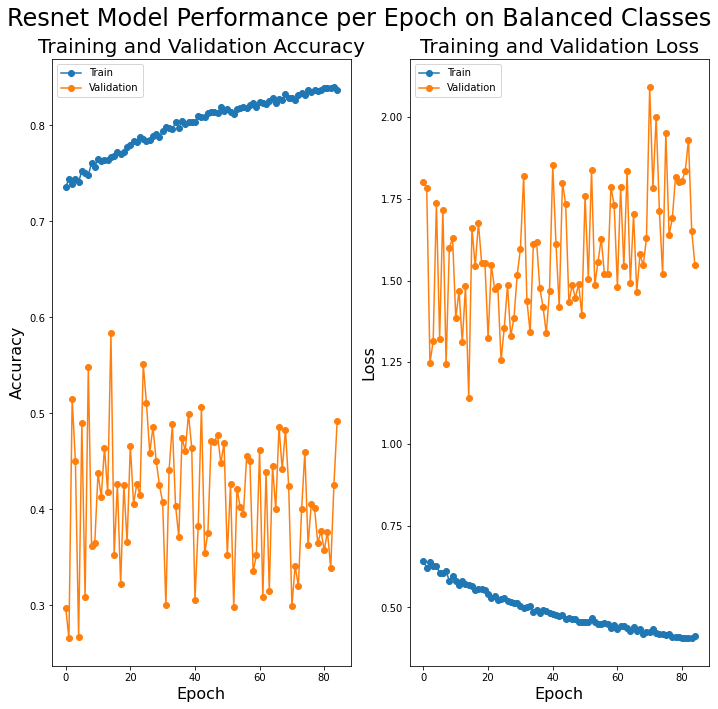

In [ ]:
plt.subplots(1, 2, figsize=(10,10))

# Creates a title for the whole plot
plt.suptitle('Resnet Model Performance per Epoch on Balanced Classes', fontsize=24)

# Plot accuracies for train and validation sets
plt.subplot(1, 2, 1)
plt.plot(hist_df['accuracy'], label='Train', marker='o')
plt.plot(hist_df['val_accuracy'], label='Validation', marker='o')
plt.title('Training and Validation Accuracy', size=20)
plt.xlabel('Epoch', size=16)
plt.ylabel('Accuracy', size=16)
plt.legend()

# Plot losses
plt.subplot(1, 2, 2)
plt.plot(hist_df['loss'], label='Train', marker='o')
plt.plot(hist_df['val_loss'], label='Validation', marker='o')
plt.title('Training and Validation Loss', size=20)
plt.xlabel('Epoch', size=16)
plt.ylabel('Loss', size=16)
plt.legend()

# This ensures the subplots do not overlap
plt.tight_layout()
plt.show()

When I had early stop to monitor the validation Loss and stopping if it didn't improve for 2 epochs then the model would stop evert 5-7 epochs. 
- looking at the plots Notice how the validation accuracy and loss fluctuate.  
- the training accuracy increased with every Epoch and the loss decreased. 

Plotting 9 of the misclassified Images. to look for a pattern to why Images are being miss classified.
I noticed that most of the misclassified images are either over or under exposed, or have some noise covering important spots in the retina 

IndexError: index 9 is out of bounds for axis 0 with size 9

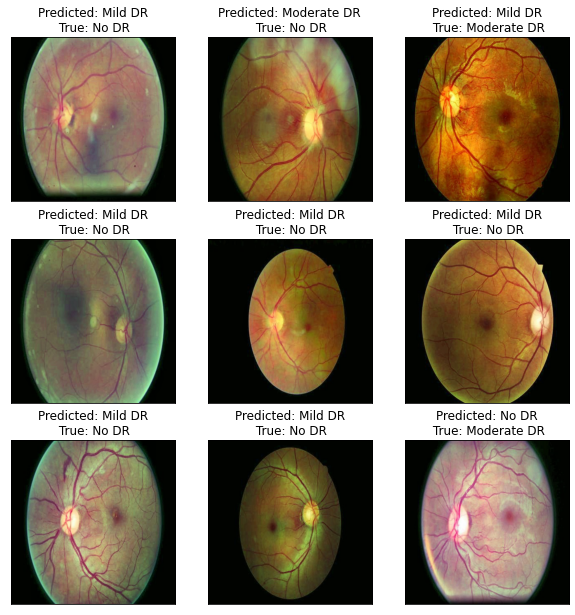

In [ ]:
import math
DR_levels = ['No DR', 'Mild DR', 'Moderate DR', 'Sever DR', 'Proliferative DR']

incorrect_photos = labels != y_predict

num_images = np.count_nonzero(incorrect_photos)
columns = 3
rows = 3

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(10, 3.5*rows))

axes = axes.flatten()

for i, image in enumerate(X_test[incorrect_photos]):
    axes[i].imshow(image, cmap='gray')

    # Get predicted label
    predicted_label = DR_levels[y_predict[incorrect_photos][i]]
    
    # Get actual label
    true_label =  DR_levels[labels[incorrect_photos][i]]
    
    # Set the title of the subplot
    axes[i].set_title(f"Predicted: {predicted_label}\n True: {true_label}")
    
    # Hide the x and y ticks to make 
    axes[i].set_xticks([]) 
    axes[i].set_yticks([])
    
fig.tight_layout()

# Hide unused subplots
for i in range(num_images, rows*columns):
    fig.delaxes(axes[i])


### DENSENET MODEL
- The steps for Densenet are very similar to RESNET50 first will download DENSENET model from the keras model Library.
- DENSENET is a pre-trained model.
- I will use the top Layers of the DENSENET model and specify the shape of my input.
- I'll freeze all the layers so that non of them are trainable.
- I will use the weights imagenet.

In [ ]:
from tensorflow.keras.applications import DenseNet201

model_densenet = DenseNet201(weights='imagenet',
                   include_top=False,
                   input_shape=(height,width,channels))
# Freezing the layers
for layer in model_densenet.layers:
    layer.trainable = False
model_densenet.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 406, 406, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 200, 200, 64  9408        ['zero_padding2d_6[0][0]']       
                                )                                                       

I will now add the last Layers.  DenseNet has 18,321,984 parameters, by freezing them they all become Non-trainable
- first i'll specify the the DENSENET model output so that my layers will run after RESNET layers.
- then I will flatten the images 
- I will add some dense Layers this will use the features that were learned from the DENSENET layers to make the final prediction.
- last I will add a softmax layer to make the prediction with 5 predictions (number of classes)
\
I have Tried adding a dropout layers to prevent over fitting but the models accuracy didn't improve over 20%

In [ ]:
from tensorflow.keras.models import Model

x = model_densenet.output 
x = Flatten()(x) 
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model_densenet = Model(inputs=model_densenet.input, 
              outputs=output)

compiling the model I used Adam optimizer with learning rate of 0.001. the loss has to be categorical_crossentropy.
- fitting the model to the training and validation data
- I ran the model for 50 epochs. 
- I will use early stop for this model and set the patience to 7 as I'm expecting fluctuations in the validation loss.
- I saved the model history and the model weights.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
csv_logger = CSVLogger("model_densenet_history_log_new.csv", append=True)
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=7, 
                           mode='min', 
                           verbose=1)
model_densenet.fit(Train_df_gen,
          epochs=50,
          validation_data = Val_df_gen,
          callbacks=[early_stop,csv_logger])
model_name = 'my_model_densenet.h5'
model_densenet.save(model_name)


Epoch 1/50
334/334 [==============================] - 862s 3s/step - loss: 1.0721 - accuracy: 0.5171 - val_loss: 1.2268 - val_accuracy: 0.1269
Epoch 2/50
334/334 [==============================] - 847s 3s/step - loss: 1.0330 - accuracy: 0.5324 - val_loss: 1.2049 - val_accuracy: 0.1421
Epoch 3/50
334/334 [==============================] - 834s 2s/step - loss: 0.9985 - accuracy: 0.5439 - val_loss: 1.4609 - val_accuracy: 0.1414
Epoch 4/50
334/334 [==============================] - 835s 2s/step - loss: 0.9828 - accuracy: 0.5478 - val_loss: 1.2031 - val_accuracy: 0.1271
Epoch 5/50
334/334 [==============================] - 852s 3s/step - loss: 0.9605 - accuracy: 0.5570 - val_loss: 1.2916 - val_accuracy: 0.1459
Epoch 6/50
334/334 [==============================] - 937s 3s/step - loss: 0.9321 - accuracy: 0.5670 - val_loss: 1.2164 - val_accuracy: 0.1537
Epoch 7/50
334/334 [==============================] - 858s 3s/step - loss: 0.9283 - accuracy: 0.5667 - val_loss: 1.2226 - val_accuracy: 0.1286

The model stopped due to an early stop. I then started training the model again but the validation accuracy didn't improve. I tried running the model with different optimizer SGD but results were not as good.

In [ ]:
# generating a 400 batch images to test the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, y_col='level',x_col = 'path',
     color_mode='rgb',path_col = test_df['path'],
     class_mode='categorical', batch_size=400, shuffle=True,target_size=(height,width))
                                                 

X_test, y_test = test_generator.next()

Found 7026 validated image filenames belonging to 5 classes.


finding the accuracy score of the densnet model, classifcation report, and confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
score = model_densenet.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Calculate the predictions
predict_probas = model_densenet.predict(X_test)
labels = np.argmax(y_test, axis=1)
# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

# Generate confusion matrix
cf_matrix = confusion_matrix(labels, y_predict)
# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predicted No DR", "Predicted Mild DR"
           ,"Predicted Moderate DR"
           ,"Predicted Sever DR"
           ,"Predicted Proliferative DR"],
    index=["True No DR", "True Mild DR"
           ,"True Moderate DR"
           ,"True Sever DR"
           ,"True Proliferative DR"])
display(cf_df)


# Classification report
report_initial = classification_report(labels, y_predict)
print(report_initial)


13/13 [==============================] - 13s 384ms/step - loss: 1.1305 - accuracy: 0.2050
Test loss: 1.1304917335510254
Test accuracy: 0.20499999821186066


,Predicted No DR,Predicted Mild DR,Predicted Moderate DR,Predicted Sever DR,Predicted Proliferative DR
True No DR,21,228,19,0,5
True Mild DR,0,30,1,0,1
True Moderate DR,8,36,12,5,7
True Sever DR,0,0,3,8,3
True Proliferative DR,0,0,0,2,11


              precision    recall  f1-score   support

           0       0.72      0.08      0.14       273
           1       0.10      0.94      0.18        32
           2       0.34      0.18      0.23        68
           3       0.53      0.57      0.55        14
           4       0.41      0.85      0.55        13

    accuracy                           0.20       400
   macro avg       0.42      0.52      0.33       400
weighted avg       0.59      0.20      0.19       400



Test accuracy is only 20%. this model actually has performed really poor compared to the other models in this notebook. 
- it's fair to say that It wasn't trained long enough to get a better score. 
- The main reason for this low score is the misclassification between class Negative DR and Mild. 
with Mild it is very hard to notice any difference in the eyes, not even the patient could notice any problems with vision. 
it is expected that the model would mix the two classes.

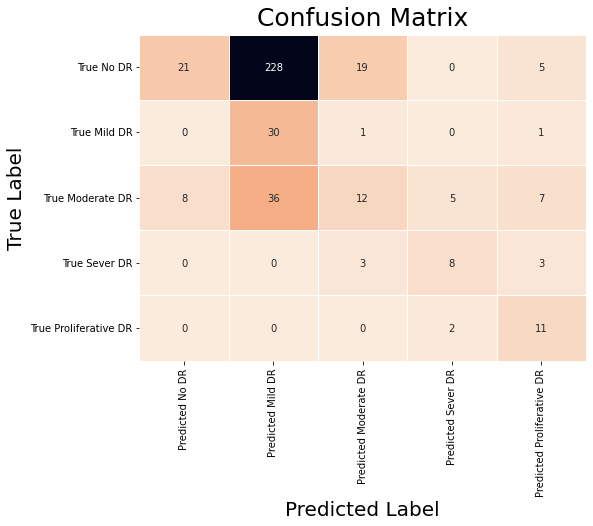

In [ ]:
# plt.title('Confusion Matrix')
plt.show()
plt.figure(figsize = (8,6))
sns.heatmap(cf_df ,
            annot=True,
            fmt='g',
            cbar=False,
            cmap="rocket_r",
            linewidths=1  )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)



plt.show()

Loading the model epochs to plot the validation, trains accuracy and loss

In [10]:
# Loading the model epochs
hist_df_new = pd.read_csv('DenseNet_model_history_log_new.csv')

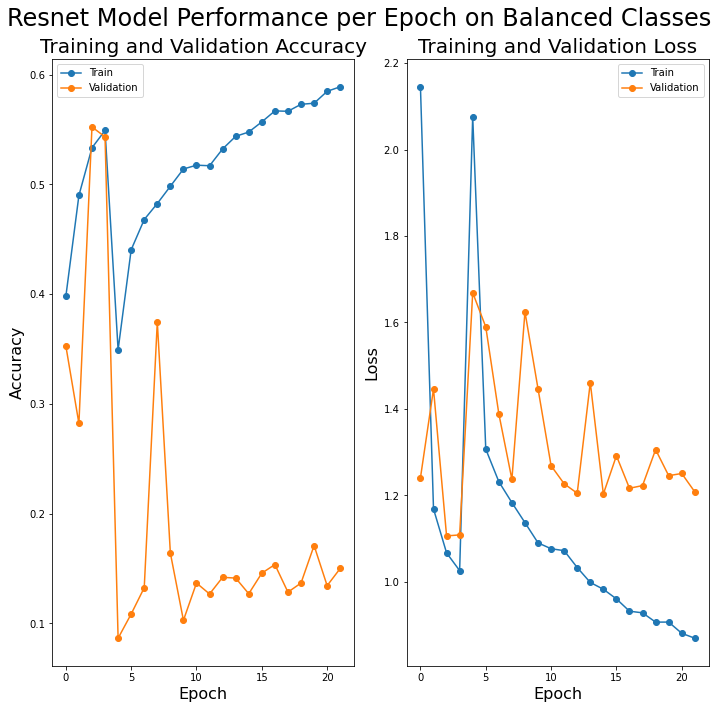

In [4]:
plt.subplots(1, 2, figsize=(10,10))

# Creates a title for the whole plot
plt.suptitle('Dense Net Performance per Epoch on Balanced Classes', fontsize=24)

# Plot accuracies for train and validation sets
plt.subplot(1, 2, 1)
plt.plot(hist_df_new['accuracy'], label='Train', marker='o')
plt.plot(hist_df_new['val_accuracy'], label='Validation', marker='o')
plt.title('Training and Validation Accuracy', size=20)
plt.xlabel('Epoch', size=16)
plt.ylabel('Accuracy', size=16)
plt.legend()

# Plot losses
plt.subplot(1, 2, 2)
plt.plot(hist_df_new['loss'], label='Train', marker='o')
plt.plot(hist_df_new['val_loss'], label='Validation', marker='o')
plt.title('Training and Validation Loss', size=20)
plt.xlabel('Epoch', size=16)
plt.ylabel('Loss', size=16)
plt.legend()

# This ensures the subplots do not overlap
plt.tight_layout()
plt.show()

Plotting misclasified Images

IndexError: ignored

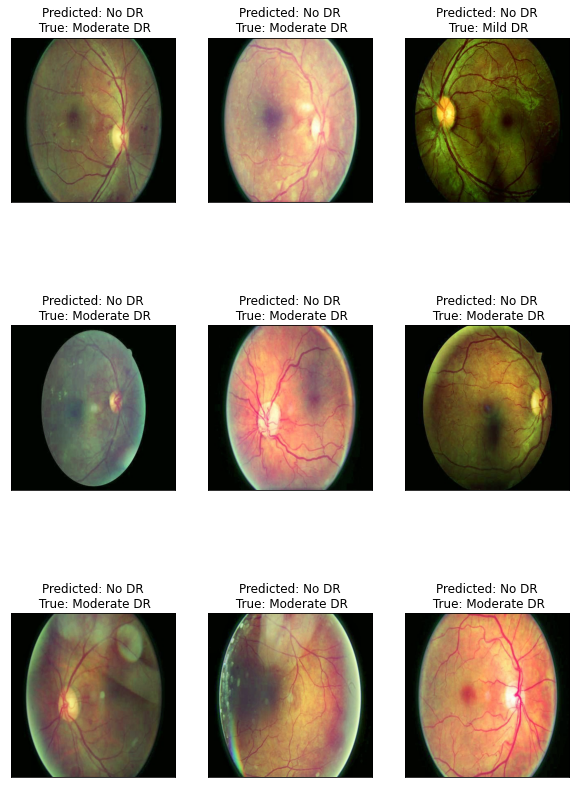

In [ ]:
# Specify the levels
DR_levels = ['No DR', 'Mild DR', 'Moderate DR', 'Sever DR', 'Proliferative DR']
# specify the misclassified images
incorrect_photos = labels != y_predict

num_images = np.count_nonzero(incorrect_photos)
columns = 3
rows = 3
# create a subplot
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(10, 5*rows))

axes = axes.flatten()
# loop through the misclassified images
for i, image in enumerate(X_test[incorrect_photos]):
    axes[i].imshow(image, cmap='gray')

    # Get predicted label
    predicted_label = DR_levels[y_predict[incorrect_photos][i]]
    
    # Get actual label
    true_label =  DR_levels[labels[incorrect_photos][i]]
    
    # Set the title of the subplot
    axes[i].set_title(f"Predicted: {predicted_label}\n True: {true_label}")
    
    # Hide the x and y ticks to make 
    axes[i].set_xticks([]) 
    axes[i].set_yticks([])
    
fig.tight_layout()

# Hide unused subplots
for i in range(num_images, rows*columns):
    fig.delaxes(axes[i])


The results are quit similar to ResNet50 Model
- Both train accuracy and loss improved over epochs
- Validation peeked at the beginning but that's due to predicting all classes to be 0, while Negative DR has the most frequency it scored A high score.

## Conclusions
- All the models performed better after running them on unbalanced classes. 
- But neither had a satisfactory performance.  
- There are many adjustments that can be made to improve the performance.  
- Due to limited time and computing power I couldn't explore every aspect of the model.
- A better Pre-processing techniques will definitely yield better results.
- tweaking the layers of the transfer learning or building specified layers would also improve the model. 
- taking a sample where class 3 and class 4 are not as balanced as the other classes could help the model learn more and differentiate between the more frequent classes.
- In the Notebook Binary classification I will train the data on the same models but I will only have 2 classes Negative and Positive.
